# A real-time combined sewer overflow and pathogen warning system
<img src="https://1702a190169a6b823f72-c3c7fc5c706f8e788f7fe0e5a5f2c7fe.ssl.cf5.rackcdn.com/WhatIsCso.jpg">
## Stephen Klosterman
steve.klosterman@gmail.com

# Table of contents
(Download and run locally for working links)
1. [Introduction](#intro)
2. [Explore rainfall/CSO relationship](#explore_cso)
    3. [Framing as a classification problem](#class)
4. [Baseline method for predicting CSO events](#baseline_cso)
5. [New model of CSO flow using rainfall and tide data](#new_cso)
    6. [Modeling approach](#approach)
    7. [Results](#results_cso)
8. [Exploratory analysis and baseline method for predicting bacteria events](#explore_bacteria)
9. [New model for bacteria events](#new_bacteria)
    10. [Results](#results_bacteria)
11. [To be done: final steps for implementation](#final_steps)
12. [Hypothetical scenario](#hypothetical)

# Introduction <a id='intro'></a>

I completed this consulting project for the 2017B session of the Insight Remote Data Science Fellows Program.  The client is the New York City Department of Environmental Protection (NYC DEP) and the goal is to inform a real-time warning system about when combined sewer overflows (CSOs) are happening, as well as when bacterial pathogen concentrations in public waterways are above a threshold level.

The data for the project are hourly rainfall data from JFK airport for the period 2002-2012, as well as deatiled mechanistic model outputs for CSO flows and waterway pathogen concentrations.  The CSO and pathogen models are not feasible to run in real time because not all of their inputs are available in real time.  Therefore the NYC DEP requires an algorithmic approach to predicting CSO flows and pathogen concentrations, using only real-time weather data as input.  NYC DEP has baseline regression models; I seek to create more accurate models.

In [68]:
#Import libraries
import pandas as pd
import numpy as np
import datetime
import statsmodels.api as sm
import sklearn
from sklearn.externals import joblib
from sklearn import linear_model
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

# Explore rainfall/CSO relationship <a id='explore_cso'></a>

First I load the data into a Pandas data frame, then format it for plotting

In [69]:
#Load the data.
path = './data/'

# #Takes ~ 1 minute to load spreadsheet
# fname = 'ci2002_2011pathogenLOADand2008nutrient_carbonLOAD_20170517D.xlsx'
# rain_cso_df = pd.read_excel(path + fname, sheetname='Outfall_pathogenLoad_part1', header=3, \
#                     index_col=2)

#Save time by saving/loading pickle
# rain_cso_df.to_pickle(path + 'rain_cso_df.pkl')

rain_cso_df = pd.read_pickle(path + 'rain_cso_df.pkl')

In [70]:
#What does it look like?
rain_cso_df.head()

,Station ID,Year,Fecal Coliform,Enterococcus,(in/hr),(MG/Hour)
(day),,,,,,
0.00000,OH-21C,2002,0.0,0.0,0.0,0.0
0.04167,OH-21C,2002,0.0,0.0,0.0,0.0
0.08333,OH-21C,2002,0.0,0.0,0.0,0.0
0.12500,OH-21C,2002,0.0,0.0,0.0,0.0
0.16667,OH-21C,2002,0.0,0.0,0.0,0.0


The variables of interest are (in/hr), which is rain fall in inches/hr, and (MG/Hour) which is outflow from the CSOs in millions of gallons per hour.  The pathogens here, Fecal Coliform and Enterococcus, are estimates of the discharge from the CSO, not the waterway concentrations I'm utlimately interested in.

The first step is to break out the data from different stations.

In [71]:
#Unique station IDs in the data set
np.unique(rain_cso_df['Station ID'])

array([u'CI-601', u'CI-602', u'OH-015', u'OH-21C', u'OH-21S', u'OH-875'], dtype=object)

In [72]:
rain_cso_df.shape

(525888, 6)

In [73]:
#Start off dataframe by subsetting to only one of the repetitions of the year series
cso_qual_df = rain_cso_df.filter(['Year'])
mask = rain_cso_df['Station ID'].isin(['OH-21C'])
cso_qual_df = cso_qual_df[mask]
cso_name = 'CSO OH-21C MG/hr'

cso_qual_df[cso_name] = rain_cso_df[rain_cso_df['Station ID'].isin(['OH-21C'])]['(MG/Hour)']
cso_qual_df['Rain, in/hr'] = rain_cso_df[rain_cso_df['Station ID'].isin(['OH-21C'])]['(in/hr)']

In [74]:
cso_qual_df.shape

(87648, 3)

In [75]:
#Create array of datetime objects to use in dataframe index, and for plotting
#Include rounding of days for whole number hours

helper = np.vectorize(lambda x: datetime.timedelta(hours=x))
start_day = datetime.datetime(2002, 1, 1)
#Change index to hours from days and round to whole hours
cso_qual_df.index = np.round(cso_qual_df.index.values*24.)
time_array = helper(cso_qual_df.index) + start_day
cso_qual_df.index = time_array

In [76]:
cso_qual_df.head()

,Year,CSO OH-21C MG/hr,"Rain, in/hr"
2002-01-01 00:00:00,2002,0.0,0.0
2002-01-01 01:00:00,2002,0.0,0.0
2002-01-01 02:00:00,2002,0.0,0.0
2002-01-01 03:00:00,2002,0.0,0.0
2002-01-01 04:00:00,2002,0.0,0.0


In [77]:
cso_qual_df.tail()

,Year,CSO OH-21C MG/hr,"Rain, in/hr"
2011-12-31 19:00:00,2011,0.0,0.0
2011-12-31 20:00:00,2011,0.0,0.0
2011-12-31 21:00:00,2011,0.0,0.0
2011-12-31 22:00:00,2011,0.0,0.0
2011-12-31 23:00:00,2011,0.0,0.0


Now that I've got the data for the CSO of interest broken out into its own dataframe, I do some exploratory visualization.  First, how often do overflows?  I plot the time series for all ten years.

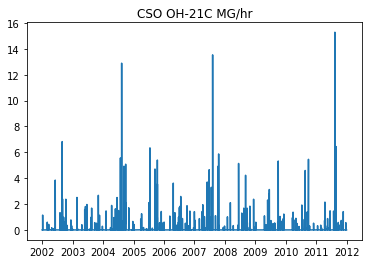

In [78]:
#Visualize CSO flow over time across the ten years
#Plots of CSO outflow over time for both CSOs
plt.plot(time_array, cso_qual_df[cso_name])
plt.title(cso_name)

The CSO appears to overflow on a regular basis over the 10 years.  I take a closer look at a two day period of both CSO flow and rainfall:

In [79]:
#Mask time series for closer look at data
plot_index = 0 #0 or 1 for either CSO

#Begin and end times for mask
mask_start_time = datetime.datetime(2011, 8, 27)
mask_end_time = datetime.datetime(2011, 8, 29)

#Vectorized way to apply test to every item of the list for a mask array
mask_series = np.vectorize(lambda testday, begin, stop: (testday >= begin) & (testday <= stop))
mask = mask_series(time_array, mask_start_time, mask_end_time)

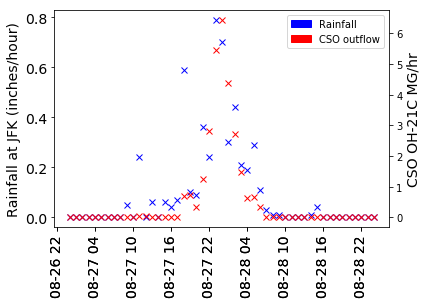

In [80]:
#Plot the rainfall and CSO outflow series

# create the general figure
fig1 = plt.figure()
font_size = 14
 
# and the first axes using subplot populated with data 
ax1 = fig1.add_subplot(111)
line1 = ax1.plot(time_array[mask], \
                 cso_qual_df['Rain, in/hr'][mask], 'bx')
plt.ylabel("Rainfall at JFK (inches/hour)", fontsize=font_size)
 
# now, the second axes that shares the x-axis with the ax1
ax2 = fig1.add_subplot(111, sharex=ax1, frameon=False)
line2 = ax2.plot(time_array[mask], \
                 cso_qual_df[cso_name][mask], 'rx')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
plt.ylabel(cso_name, fontsize=font_size)

#Adjust tick labels
labels = ax1.get_xticklabels()
plt.setp(labels, rotation=90, fontsize=font_size)
labels = ax2.get_xticklabels()
plt.setp(labels, rotation=90, fontsize=font_size)
ax1.tick_params(labelsize=font_size)

#Make legend using proxy artist
blue_patch = mpl.patches.Patch(color='blue', label='Rainfall')
red_patch = mpl.patches.Patch(color='red', label='CSO outflow')
plt.legend(handles=[blue_patch, red_patch])

# plt.title(cso_names[plot_index])

plt.show()

It seems clear that rainfall events happen about the same time as overflow events.  It also looks like the overflow lasts a little while after the end of the rain event.  This makes sense because the sewer system would be full of storm water and sanitary sewage, and need some time to drain.

Now to get a broader view of what the relation of rainfall to CSO outflow is, I look at a scatter plots between these two variables over the 10 year time frame and calculate the correlation coefficient.

In [81]:
#Define a little function to plot any column against rainfall as a scatter and display
#correlation, and use it twice
def cso_scatter(column_name):
    title_str = column_name + ': r = {:0.2f}'.format(\
          cso_qual_df['Rain, in/hr'].\
          corr(cso_qual_df[column_name]))
    cso_qual_df.plot.scatter(x='Rain, in/hr', y=column_name)
    plt.title(title_str)
    

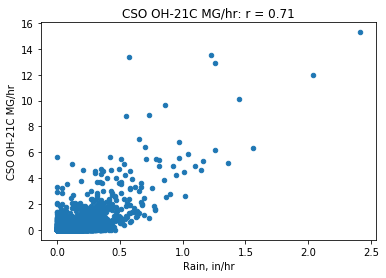

In [82]:
cso_scatter(cso_name)

Concurrent rainfall and CSO overflows are highly correlated over the entire dataset.  In the next section, I implement the NYC DEP's existing baseline model for CSO occurrence.  Then in the following section, I explore another approach.

## Framing as a classification problem <a id='class'></a>

First, though, as a final data exploration step, I binarize the cso outflow data:  any time when a CSO is occurring is labeled "1", and when it's not occuring is labeled "0".  This facilitates modeling with the ultimate deliverable in mind:  a warning system for when CSOs are occurring, versus when they're not.

First I explore the class proportion of this classification problem:

In [83]:
cso_occur = np.sum(cso_qual_df[cso_name]>0)
print('Fraction of CSO events in data set 1 is {:0.5f}'\
      .format(np.float(cso_occur)/len(cso_qual_df[cso_name].values)))

Fraction of CSO events in data set 1 is 0.01343


There is a large class imbalance here.  This is challenging in classification, and may make it difficult to detect events.  If recovery of true positives, i.e. successfully identifying times of events, is low, this may require action.  I will assess this later.  For now I binarize the CSO outflow data:

In [84]:
cso_qual_df.loc[cso_qual_df[cso_name] > 0, cso_name] = 1

In [85]:
# cso_qual_df.head(1000)

# Baseline method for predicting CSO events <a id='baseline_cso'></a>

The NYC DEP's method for calculating combined sewer overflow events is based on the amount of time during and after a rainfall event.  A rainfall event is defined as any period of rainfall that is separated by at least four hours from another period of rainfall.  The rainfall events are contained in a spreadsheet which I load here:

In [86]:
# #Load rainfall events data
# fname = '2002 to 2011 Storm Event Summary.xlsx'
# rain_events_df = pd.read_excel(path + fname, sheetname='2002 to 2011 Summary', header=0, \
#                     index_col=0)

#Pickle
# rain_events_df.to_pickle(path + 'rain_events_df.pkl')
rain_events_df = pd.read_pickle(path + 'rain_events_df.pkl')

In [87]:
#Drop unnecessary rows, show head of dataframe
rain_events_df.drop(rain_events_df.index[[0, 1, 2, 3]], inplace=True)
rain_events_df.head()

,Event End,Event Duration (hrs),Peak Intensity (in/hour),Total Rainfall depth (in),Time of Peak
Event Start,,,,,
2002-01-06 17:00:00,2002-01-06 22:00:00,5.0,0.26,0.75,2002-01-06 19:00:00
2002-01-07 12:00:00,2002-01-07 13:00:00,1.0,0.01,0.01,2002-01-07 12:00:00
2002-01-07 17:00:00,2002-01-07 21:00:00,4.0,0.01,0.04,2002-01-07 17:00:00
2002-01-09 10:00:00,2002-01-09 15:00:00,5.0,0.04,0.10,2002-01-09 14:00:00
2002-01-11 07:00:00,2002-01-11 13:00:00,6.0,0.06,0.21,2002-01-11 09:00:00


The baseline model assumes CSO events happen for a period of twelve hours after the end of each rain event.  This is implemented here as an array of 1's, for times during a CSO event, and 0's elsewhere.

In [88]:
#Boolean mask with location in the cso_qual_df of where rain event end times are
#This has length the same as cso_qual_df and sum equal to the length of rain_events_df
event_end_mask = cso_qual_df.index.isin(rain_events_df['Event End'].values)
#Integer indices of the above, event_end_indices[0] has length equal to rain_events_df
event_end_indices = np.nonzero(event_end_mask)

#Get same for event start times
event_start_mask = cso_qual_df.index.isin(rain_events_df.index.values)
event_start_indices = np.nonzero(event_start_mask)


In [89]:
# event_start_indices[0]

In [90]:
# event_end_indices

In [91]:
#The baseline model for when there is a CSO happening.  Start with all zeros
baseline_cso = np.zeros(cso_qual_df.shape[0])
#Then for every index in event_end_indices, make that element and the subsequent eleven elements into ones
for event_start_index, event_end_index in zip(event_start_indices[0], event_end_indices[0]):
    baseline_cso[event_start_index:event_end_index+12] = 1
# sum(baseline_cso)/12 = 1128.1666666666667, while len(rain_events_df) = 1191
#seems to imply some rain events start before the 12 hours after the last one is over

Now I have the baseline model, which is the same for all CSOs.  I calculate the accuracy as fraction of model values that are correct.

In [92]:
baseline_acc = np.empty(2,)
baseline_acc = sum(cso_qual_df[cso_name].values == baseline_cso)/np.float(len(baseline_cso))

print('Accuracy of baseline model: {:0.2f}'.format(baseline_acc))

Accuracy of baseline model: 0.78


Perhaps more important than accuracy for this problem are the true and false positive rates.  These are the fraction of times when the warning system would correctly warn of an overflow, or incorrectly issue a warning when there is not actually an overflow, respectively.

In [93]:
#True positive rate
#true positives/positives
#False positive rate = n false positives / total negatives
n_false_pos = sum( (cso_qual_df[cso_name].values==0) & (baseline_cso==1) )
n_true_pos = sum( (cso_qual_df[cso_name].values==1) & (baseline_cso==1) )
total_neg = sum(cso_qual_df[cso_name].values==0)
total_pos = sum(cso_qual_df[cso_name].values==1)
false_pos_rate = n_false_pos/np.float(total_neg)
true_pos_rate = n_true_pos/np.float(total_pos)

print(false_pos_rate, true_pos_rate, total_neg, total_pos)

(0.22202819442356397, 0.84112149532710279, 86471, 1177)


So the baseline model has a false positive rate of 22%, and true positive rate of 84%.

# New model of CSO flow using rainfall and tide data <a id='new_cso'></a>

First, I get the unique years in the data set.  This will be used to split the data into 10 folds for cross validation.

In [94]:
#Get unique years
un_years = np.unique(cso_qual_df['Year'])
print(un_years, 'length', len(un_years))

(array([2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011]), 'length', 10)


Next, I load additional data.  Since combined sewer overflows are affected by tides as well as rainfall, I include this as a predictor.  This can be implemented in the final deliverable since it is available in real time.

In [95]:
# load tides/temps data and add
tides_temps_df = pd.read_pickle('./addl_climate_data/tides_temps_df.pkl')
# merge; should have same index
cso_qual_df = cso_qual_df.merge(tides_temps_df, how='inner', left_index=True, right_index=True)
cso_qual_df.head()

,Year,CSO OH-21C MG/hr,"Rain, in/hr",Tide prediction (ft),Air temp (F)
2002-01-01 00:00:00,2002,0.0,0.0,1.497,25.00
2002-01-01 01:00:00,2002,0.0,0.0,0.395,24.00
2002-01-01 02:00:00,2002,0.0,0.0,-0.360,24.85
2002-01-01 03:00:00,2002,0.0,0.0,-0.539,23.85
2002-01-01 04:00:00,2002,0.0,0.0,0.111,22.85


## Modeling approach <a id='approach'></a>
I use a classification version of a time series regression model called distributed lag (https://en.wikipedia.org/wiki/Distributed_lag).  The idea is that the dependent variable at the current time step is a linear regression of the predictors at the current time step, as well as some number of previous time steps.  However in this case the dependent variable is binary (i.e. CSO outflow is happening or not) so instead of linear regression I use logistic regression.  An advantage of this approach is that it directly calculates the probability of the outcome of interest (outflow happening or not), and allows for tuning of the treshold probability to predict the event, providing control over true/false positive rates.

Here I define model training and testing functions.  The training function serves to fit a model for each fold in the training set.  For example, it will fit a model using 2003-2011 data, which will be tested on 2002 data.  Based on the number of lags and which predictors are specified, the training function will create a data frame for internal function use, with additional columns for each time lag, for each predictor.

In [96]:
#Inputs
#model: sklearn model for traning and testing
#lag_order: positive integer, number of time lags (hours) to include in addition to current point in model
#column_to_model: string, column name from Pandas dataframe that will be used as response variable
#predictors: list of strings, column names from Pandas dataframe that will be used as predictors
#
#Outputs
#est: list of trained sklearn model objects

def train_model(model, lag_order, column_to_model, predictors):
    #Empty list for trained models
    est = [None]*len(un_years)

    #Loop to train separately on each year
    for year_index in range(len(un_years)):
        #Subset the data to all but this year, for training
        train_data = \
            cso_qual_df[~cso_qual_df['Year'].isin([un_years[year_index]])]
            
        #Get indices of next year for use below, to get rid of inappropriate lags
        #in training data
        if (year_index > 0) & (year_index < (len(un_years)-1)):
            next_year_indices = train_data['Year'].isin([un_years[year_index+1]])
            
        #Filter to only include columns used here for model training
        filter_columns = predictors[:] #create copy of list of predictors
        filter_columns.append(column_to_model) #append the response variable
        train_data = train_data.filter(filter_columns, axis=1)

        #Create time lagged columns for each predictor
        for this_lag in range(1,lag_order+1):
            for this_pred in predictors:
                train_data.insert\
                    (0, this_pred + ' lag '+ str(this_lag),\
                    train_data[this_pred].shift(this_lag))

        #Need to throw out the first 'lag_order' rows of the year after the year
        #removed for testing: these lags refer to over a year ago, which doesn't make sense.
        #Don't need to do this for the first (since these are already
        #removed by removing NaNs) or last (since there is no year after this) years
        if (year_index > 0) & (year_index < (len(un_years)-1)):
            train_data.drop\
                (train_data.index[np.nonzero(next_year_indices)[0:lag_order+1]], inplace=True)
        
        #Drop rows with NaNs that were introduced by shifting to get lags
        train_data.dropna(axis=0, inplace=True)

        #Make arrays of predictors and response
        X = train_data.drop([column_to_model], axis=1).values
        y = train_data.filter([column_to_model], axis=1).values
     
        #Fit model in sklearn
        est[year_index] = model.fit(X, y)
        
    #Return list of trained models
    return est

This testing function should take the same inputs as the corresponding training run, except it takes an array of trained models ('est', output from corresponding training run) instead of an untrained one.  It returns various model fit statistics for each fold.

In [97]:
#Outputs
#all_test_proba: list (by year) of arrays of probabilities for each class for each sample
#all_test_roc: list (by year) of output from sklearn.metrics.roc_curve function
#sklearn_metrics: list (by year) of classification statistics from sklearn.metrics.precision_recall_fscore_support
#all_test_acc: array of accuracies for each year

def test_model(est, lag_order, column_to_model, predictors):
    # Model testing
    y_pred = [None]*len(un_years)
    y_data = [None]*len(un_years)
    sklearn_metrics = [None]*len(un_years)
    all_test_proba = [None]*len(un_years)
    all_test_roc = [None]*len(un_years)
    all_test_acc = np.array([])

    #Loop to test each year
    for year_index in range(len(un_years)):
        #Subset the data to this year for testing
        test_data = \
            cso_qual_df[cso_qual_df['Year'].isin([un_years[year_index]])]
            
        #Filter to only include columns used here for model training
        filter_columns = predictors[:] #create copy of list of predictors
        filter_columns.append(column_to_model) #append the response variable
        test_data = test_data.filter(filter_columns, axis=1)

        #Create time lagged columns for predictors in test data
        for this_lag in range(1,lag_order+1):
            for this_pred in predictors:
                test_data.insert\
                    (0, this_pred + ' lag '+ str(this_lag),\
                    test_data[this_pred].shift(this_lag))
                  
        #Drop rows with NA that were introduced by shifting to get lags
        test_data.dropna(axis=0, inplace=True)
        
        #Get predictors
        X = test_data.drop([column_to_model], axis=1).values
        #Do prediction
        y_pred[year_index] = est[year_index].predict(X)
        all_test_proba[year_index] = est[year_index].predict_proba(X)
        #Get actual values
        y_data[year_index] = \
        test_data.filter([column_to_model], axis=1)[column_to_model].values
        #Get roc curve
        all_test_roc[year_index] = sklearn.metrics.roc_curve(y_data[year_index], all_test_proba[year_index][:,1])
        #Get accuracy, other metrics of prediction
        all_test_acc = np.append(all_test_acc, est[year_index].score(X, y_data[year_index]))
        sklearn_metrics[year_index] = \
        sklearn.metrics.precision_recall_fscore_support(y_data[year_index], y_pred[year_index])
        
    return all_test_acc, all_test_proba, all_test_roc, sklearn_metrics

Now that the model is defined, I use it to explore how true positive rate changes with the number of lags.  I start with only one predictor:  hourly rainfall.  When defining the logistic regression model object, I ask for an intercept for better fit, for class balancing to be done since there are unbalanced classes, and I set the regularization parameter to be very large since I am being explicit about what predictors are included, as opposed to trying a large number of predictors without knowing which are important.

In [98]:
# #Create a logistic model object for training/testing
# from sklearn import linear_model
# logistic_reg_model = linear_model.LogisticRegression(fit_intercept = True, class_weight='balanced', C=1000000)

# #Try lag orders from 1 to 12
# lags_to_try = range(1,13)
# all_test_acc = [[]]*len(lags_to_try)
# all_test_proba = [[]]*len(lags_to_try)
# all_test_roc = [[]]*len(lags_to_try)
# sklearn_metrics = [[]]*len(lags_to_try)

# for lag_order in lags_to_try:
#     est = train_model(model=logistic_reg_model,\
#     lag_order=lag_order,\
#     column_to_model=cso_name,\
#     predictors=['Rain, in/hr'])
    
#     [all_test_acc[lag_order-1], all_test_proba[lag_order-1],\
#     all_test_roc[lag_order-1], sklearn_metrics[lag_order-1]] = \
#     test_model(est=est,\
#     lag_order=lag_order,
#     column_to_model=cso_name,\
#     predictors=['Rain, in/hr'])

# #Takes ~20 seconds to run

Since the above takes a little while to run, I can run the following cell to save the results locally.  The cell after that loads them.

In [99]:
# #Filename describing what's here
# fname = 'metrics_cso_1_preds_lags_1_to_12.pkl'
# joblib.dump([lags_to_try, all_test_acc, all_test_proba,\
#             all_test_roc, sklearn_metrics], fname, compress=9)

In [100]:
fname = 'metrics_cso_1_preds_lags_1_to_12.pkl'
[lags_to_try, all_test_acc, all_test_proba,\
            all_test_roc, sklearn_metrics] = joblib.load(fname)

## Results <a id='results_cso'></a>
Here I plot the average true positive rate over the 10 folds.

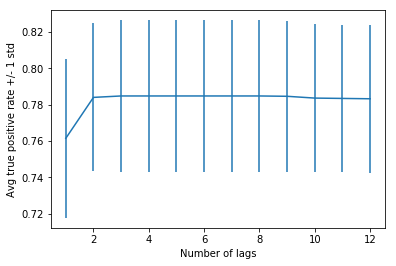

In [101]:
#Plot of mean and std dev across the cross validation
mean_stat = np.array([])
std_stat = np.array([])

for lag_order in lags_to_try:
#     print(lag_order)
    this_lag_order_tpr = np.array([])
    
    for year_index in range(np.shape(sklearn_metrics[lag_order-1])[0]):
        #Get true positive rate
        this_lag_order_tpr = np.append(this_lag_order_tpr, sklearn_metrics[lag_order-1][year_index][1][1])
    
    mean_stat = np.append(mean_stat, np.mean(this_lag_order_tpr))
    std_stat = np.append(std_stat, np.std(this_lag_order_tpr))
    
# plt.plot(several_lags, mean_r_sq)
plt.errorbar(lags_to_try, mean_stat, yerr=std_stat)
plt.xlabel('Number of lags')
plt.ylabel('Avg true positive rate +/- 1 std')
plt.title('')

It looks like there is not much additional benefit to including more than 2 lags.  However I know that tides are also relevant to CSO outflows, so I include the tide data as a predictor and redo this analysis.

In [102]:
# #Try lag orders from 1 to 12
# lags_to_try = range(1,13)
# all_test_acc = [[]]*len(lags_to_try)
# all_test_proba = [[]]*len(lags_to_try)
# all_test_roc = [[]]*len(lags_to_try)
# sklearn_metrics = [[]]*len(lags_to_try)

# for lag_order in lags_to_try:
#     est = train_model(model=logistic_reg_model,\
#     lag_order=lag_order,\
#     column_to_model=cso_name,\
#     predictors=['Rain, in/hr', 'Tide prediction (ft)'])
    
#     [all_test_acc[lag_order-1], all_test_proba[lag_order-1],\
#     all_test_roc[lag_order-1], sklearn_metrics[lag_order-1]] = \
#     test_model(est=est,\
#     lag_order=lag_order,
#     column_to_model=cso_name,\
#     predictors=['Rain, in/hr', 'Tide prediction (ft)'])

In [103]:
# #Filename describing what's here
# fname = 'metrics_cso_2_preds_lags_1_to_12.pkl'
# joblib.dump([lags_to_try, all_test_acc, all_test_proba,\
#             all_test_roc, sklearn_metrics], fname, compress=9)

In [104]:
fname = 'metrics_cso_2_preds_lags_1_to_12.pkl'
[lags_to_try, all_test_acc, all_test_proba,\
            all_test_roc, sklearn_metrics] = joblib.load(fname)

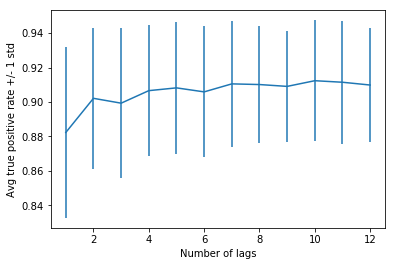

In [105]:
#Plot of mean and std dev across the cross validation
mean_stat = np.array([])
std_stat = np.array([])

for lag_order in lags_to_try:
#     print(lag_order)
    this_lag_order_tpr = np.array([])
    
    for year_index in range(np.shape(sklearn_metrics[lag_order-1])[0]):
        #Get true positive rate
        this_lag_order_tpr = np.append(this_lag_order_tpr, sklearn_metrics[lag_order-1][year_index][1][1])
    
    mean_stat = np.append(mean_stat, np.mean(this_lag_order_tpr))
    std_stat = np.append(std_stat, np.std(this_lag_order_tpr))
    
# plt.plot(several_lags, mean_r_sq)
plt.errorbar(lags_to_try, mean_stat, yerr=std_stat)
plt.xlabel('Number of lags')
plt.ylabel('Avg true positive rate +/- 1 std')
plt.title('')

Including tide level as a predictor increases the true positive rate from the high seventies to around 90%.  So this seems like a good idea.  True positive rate increases with lag until about 10 lags; I move forward with 12 lags since the rate is about the same, and wisdom from the baseline approach points to considering 12 hours after a rainfall event.

Now that the number of lags and the predictors are determined, I examine the true/false positive rates.  The rates plotted above come from the default threshold of 0.50.  However the outputs of the logistic regression are class probabilities for either class (event/non-event), and the threshold for identifying an event can be adjusted to increase the true positive rate.  This however comes at the expense of increasing the false positive rate.  This tradeoff can be visualized using what's called an ROC curve:

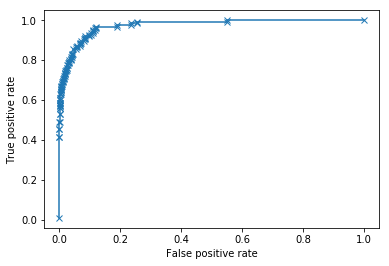

In [106]:
# Plot ROC curve for 12 lags (index 11), choose year.
year_to_plot = 0
plt.plot(all_test_roc[11][year_to_plot][0], all_test_roc[11][year_to_plot][1], '-x')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

Each point on the graph represents a threshold rate, starting with 100% at which no samples are identified as positive, decreasing to 0% at which all samples are identified, resulting in 100% true and false positive rates.  A desirable classifier hugs the upper left corner of this plot; this means the true positive rate (TPR) is fairly high, while the false positive rate (FPR) is low.

A TPR of 90% has been indicated, so I examine the corresponding thresholds and FPRs for each year.  First I collect this data, then plot it and note the averages

In [107]:
want_true_pos = 0.90;

actual_true_pos = np.array([])
false_pos_rate_for_this_true_pos = np.array([])
thresh_for_this_true = np.array([])

lag_order = 12

for year_index in range((len(un_years))):
    #The difference between desired and all true positive rates in the ROC curve
    roc_diff = all_test_roc[lag_order-1][year_index][1] - want_true_pos
    #Index of the closest to desired
    roc_index = np.argmin(np.abs(roc_diff))
    actual_true_pos = np.append(actual_true_pos, all_test_roc[lag_order-1][year_index][1][roc_index])
    false_pos_rate_for_this_true_pos = np.append(false_pos_rate_for_this_true_pos, all_test_roc[lag_order-1][year_index][0][roc_index])
    thresh_for_this_true = np.append(thresh_for_this_true, all_test_roc[lag_order-1][year_index][2][roc_index])
    
#     #Print percent of negative classifications
#     print(sum(all_test_proba[lag_order-1][year_index][:,1] < \
#               thresh_for_this_true[year_index])/np.float(len(all_test_proba[lag_order-1][year_index][:,1])))

In [108]:
#These should be close to 0.9
actual_true_pos

array([ 0.896     ,  0.89915966,  0.89705882,  0.8984375 ,  0.8974359 ,
        0.89915966,  0.89915966,  0.8989899 ,  0.89655172,  0.90322581])

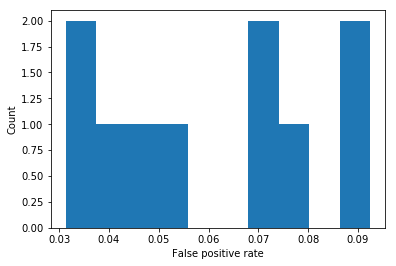

In [109]:
plt.hist(false_pos_rate_for_this_true_pos)
plt.xlabel('False positive rate')
plt.ylabel('Count')

In [110]:
np.mean(false_pos_rate_for_this_true_pos)

0.060608998711114012

So for a TPR of 90%, higher than the baseline model, the average FPR for the validation data is 6%, lower than the baseline model.

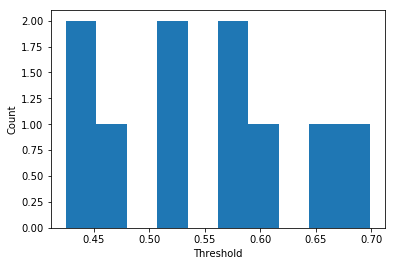

In [48]:
plt.hist(thresh_for_this_true)
plt.xlabel('Threshold')
plt.ylabel('Count')

I note that the thresholds for obtaining 90% TPR are in the neighborhood of 50%, the default.

For the final deliverable model, I will train on all the years of data together.

# Exploratory analysis and baseline method for predicting bacteria events <a id='explore_bacteria'></a>

The next step is to develop a model for bacteria concentrations.  First I load the data frame with hourly pathogen concentrations.  The pathogen of interest is fecal coliform (FC).

In [111]:
#Load pathogen data and add it to the data frame

# fname = 'ci_baseline_2002_2011pathogen_and_2008dissolved_oxygen_20170509B.xlsx'
# patho_df = pd.read_excel(path + fname, sheetname='ten_year_pathogen', header=3, \
#                     index_col=2)

#Pickle for faster loading
# patho_df.to_pickle(path + 'patho_df.pkl')  # where to save it, usually as a .pkl
patho_df = pd.read_pickle(path + 'patho_df.pkl')

In [112]:
patho_df.head()

,Station ID,Year,Fecal Coliform,Enterococcus,Station ID.1,Fecal Coliform.1,Enterococcus.1,Station ID.2,Fecal Coliform.2,Enterococcus.2,(in/hr)
(day),,,,,,,,,,,
0.00000,CIC2,2002,44,30,CIC3,37,19,GB1,28,7,0.0
0.04167,CIC2,2002,44,30,CIC3,37,19,GB1,29,7,0.0
0.08333,CIC2,2002,41,27,CIC3,36,19,GB1,31,8,0.0
0.12500,CIC2,2002,39,25,CIC3,35,17,GB1,36,10,0.0
0.16667,CIC2,2002,38,25,CIC3,34,17,GB1,38,11,0.0


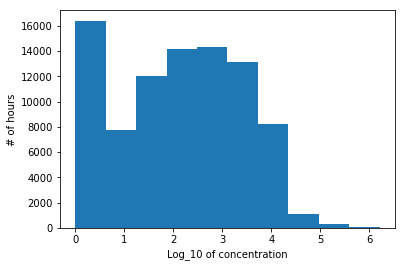

In [113]:
#Plot results for first FC time series
plt.hist(np.log10(patho_df['Fecal Coliform']))
plt.xlabel('Log_10 of concentration')
plt.ylabel('# of hours')

Next I implement the baseline model for bacteria concentrations, for comparison to model development efforts.  This is an attempt to recreate the model described in the Word Document 'CSO Advisory Calculation Methodology 10-23-08.doc' from Hydroqual.  The basic idea is to use the volume of rainfall events, as defined above and used in the baseline model for CSOs, as the predictor in a linear regression for bacteria concentrations at various times after the end of the rainfall event.  To be conservative, I assume the bacteria concentration during and for 12 hours after the end of the rainfall event is equal to the maximum during this time period.  Then the concentration from 12 to 24 hours is assumed equal to the concentration at 12 hours, and similar for 12 hour periods up through 60 hours.

In [114]:
#Need to find
#Maximum FC concentration during, or in the 12 hours following end of rainfall event
#Also
#FC concentrations at 12, 24, 36, and 48 hours after.  Each will be used to define warning status for the 11
#hours after that time point.  Assumption that warning ends at 60 hours.

fc_max_in_12_h = np.empty(np.shape(event_end_indices[0]))
fc_12_h = np.empty(np.shape(event_end_indices[0]))
fc_24_h = np.empty(np.shape(event_end_indices[0]))
fc_36_h = np.empty(np.shape(event_end_indices[0]))
fc_48_h = np.empty(np.shape(event_end_indices[0]))

#Select column name to get baseline model accuracy score
column_name = 'Fecal Coliform'

counter = 0

#Use rain start and end times to get bacteria concentrations
for event_start_index, event_end_index in zip(event_start_indices[0], event_end_indices[0]):
    fc_max_in_12_h[counter] = np.max(patho_df[column_name].iloc[event_start_index:event_end_index+12])
    fc_12_h[counter] = patho_df[column_name].iloc[event_end_index+12]
    fc_24_h[counter] = patho_df[column_name].iloc[event_end_index+24]
    fc_36_h[counter] = patho_df[column_name].iloc[event_end_index+36]
    fc_48_h[counter] = patho_df[column_name].iloc[event_end_index+48]

    counter = counter + 1

#Now each one of these gets its own linear model with rainfall event volume
ols_model = linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)
#Predictor is volume of rainfall event
rainfall_depth = rain_events_df['Total Rainfall depth                 (in)'].values.reshape(-1,1)

#Note: modeling log-transformed responses resulted in a null model of no events, as modeled concentrations were
#always < 1000, so I stick with the untransformed concentrations
model_12_hr_max = ols_model.fit(rainfall_depth, np.log10(fc_max_in_12_h))
model_12_hr = ols_model.fit(rainfall_depth,fc_12_h)
model_24_hr = ols_model.fit(rainfall_depth, fc_24_h)
model_36_hr = ols_model.fit(rainfall_depth, fc_36_h)
model_48_hr = ols_model.fit(rainfall_depth, fc_48_h)

#Build array using predicted concentration at each time interval, throughout that interval
#after each rainfall event
#Zero
baseline_fc_model = np.zeros(np.shape(patho_df[column_name].values))
#Except after rainfall events
counter = 0
for event_end_index in event_end_indices[0]:
    this_rainfall_val = rainfall_depth[counter].reshape(1,-1)
    baseline_fc_model[event_end_index:event_end_index+12] = model_12_hr_max.predict(this_rainfall_val)
    baseline_fc_model[event_end_index+12:event_end_index+24] = model_12_hr.predict(this_rainfall_val)
    baseline_fc_model[event_end_index+24:event_end_index+36] = model_24_hr.predict(this_rainfall_val)
    baseline_fc_model[event_end_index+36:event_end_index+48] = model_36_hr.predict(this_rainfall_val)
    baseline_fc_model[event_end_index+48:event_end_index+60] = model_48_hr.predict(this_rainfall_val)
    
    counter = counter + 1
    
#Set negatives to zero
baseline_fc_model[baseline_fc_model<0] = 0

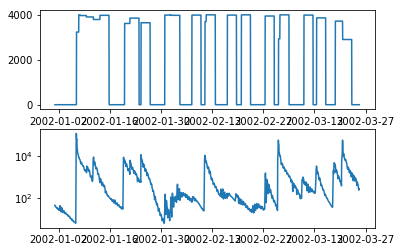

In [115]:
#Visualize simulated bacteria events, according to the baseline model, and the reported ones
plt.subplot(2,1,1)
plt.plot(cso_qual_df.index.values[0:2000], baseline_fc_model[0:2000])
#And this is the data set
plt.subplot(2,1,2)
plt.plot(cso_qual_df.index.values[0:2000], patho_df[column_name].iloc[0:2000])
plt.yscale('log')

The baseline model for bacteria concentrations looks reasonable in timing, although not in value:  concentrations are predicted to be too low.  However as long they are above 1000, they will trigger the warning, so it seems adequate for my purposes here.

Now I binarize the predictions and data, and determine accuracy for finding times when FC > 1000.

In [116]:
baseline_fc_model_bin = baseline_fc_model > 1000
data_bin = patho_df[column_name].values > 1000
baseline_fc_accuracy = sum(baseline_fc_model_bin == data_bin)/float(len(baseline_fc_model_bin))
print('Accuracy of baseline bacteria model is {:0.2f}'.format(baseline_fc_accuracy))

Accuracy of baseline bacteria model is 0.67


In [117]:
#True positive rate
#true positives/positives
#False positive rate = n false positives / total negatives
n_false_pos = sum( (data_bin==0) & (baseline_fc_model_bin==1) )
n_true_pos = sum( (data_bin==1) & (baseline_fc_model_bin==1) )
total_neg = sum(data_bin==0)
total_pos = sum(data_bin==1)
false_pos_rate = n_false_pos/np.float(total_neg)
true_pos_rate = n_true_pos/np.float(total_pos)

print(false_pos_rate, true_pos_rate, total_neg, total_pos)

(0.40563249044115285, 0.8718211164475238, 62246, 25402)


The baseline model recovers a high percentage of true positives (87%) but also has a relatively large amount of false positives (41%).  Note that these model statistics are generous, as the model is being assessed using predictions on the training data.  When developing the new model below I return to standard machine learning practice of assessing model performance using predictions on out-of-sample data.

For consideration of hypothetical scenarios below, what is the proportion of negative classifications?  These would be the times when the water is predicted to be safe according to < 1000 colonies FC / 100 mL of water.

In [118]:
#%Negative classifications
baseline_neg_classes = sum(baseline_fc_model_bin==0)/np.float(len(baseline_fc_model_bin))
baseline_neg_classes

0.4592574844833881

# New model for bacteria events <a id='new_bacteria'></a>

I use a similar modeling approach here to the CSO approach above, except also considering temperature as a predictor, as this is a factor in bacteria metabolism.

First I binarize the data according to the 1000 colony rule, and add it to the data frame with the CSO volumes, in order to use the same modeling functions.

In [119]:
regulation_limit = 1000. #this could be updated if regulations change

cso_qual_df['Fecal Coliform 1'] = patho_df['Fecal Coliform'].values
cso_qual_df.loc[cso_qual_df['Fecal Coliform 1'] < regulation_limit, 'Fecal Coliform 1'] = 0
cso_qual_df.loc[cso_qual_df['Fecal Coliform 1'] >= regulation_limit, 'Fecal Coliform 1'] = 1

cso_qual_df['Fecal Coliform 2'] = patho_df['Fecal Coliform.1'].values
cso_qual_df.loc[cso_qual_df['Fecal Coliform 2'] < regulation_limit, 'Fecal Coliform 2'] = 0
cso_qual_df.loc[cso_qual_df['Fecal Coliform 2'] >= regulation_limit, 'Fecal Coliform 2'] = 1

cso_qual_df['Fecal Coliform 3'] = patho_df['Fecal Coliform.2'].values
cso_qual_df.loc[cso_qual_df['Fecal Coliform 3'] < regulation_limit, 'Fecal Coliform 3'] = 0
cso_qual_df.loc[cso_qual_df['Fecal Coliform 3'] >= regulation_limit, 'Fecal Coliform 3'] = 1

In [120]:
cso_qual_df.head()
# patho_df.shape

,Year,CSO OH-21C MG/hr,"Rain, in/hr",Tide prediction (ft),Air temp (F),Fecal Coliform 1,Fecal Coliform 2,Fecal Coliform 3
2002-01-01 00:00:00,2002,0.0,0.0,1.497,25.00,0,0,0
2002-01-01 01:00:00,2002,0.0,0.0,0.395,24.00,0,0,0
2002-01-01 02:00:00,2002,0.0,0.0,-0.360,24.85,0,0,0
2002-01-01 03:00:00,2002,0.0,0.0,-0.539,23.85,0,0,0
2002-01-01 04:00:00,2002,0.0,0.0,0.111,22.85,0,0,0


In [121]:
len(cso_qual_df['Fecal Coliform 1'])
n_FC_events = np.sum(cso_qual_df['Fecal Coliform 1'].values)
print('Fraction of bacteria events in data is {:0.3f}'.\
      format(np.float(n_FC_events)/len(cso_qual_df['Fecal Coliform 1'])))

Fraction of bacteria events in data is 0.290


Here I will consider only the first FC time series.  The fraction of bacteria events is 0.29, so the classes are more balanced than with the CSO data.

In [122]:
# #Now run quality model for many lags
# #Will want to save these results to avoid running again
# import timeit
# start_time = timeit.default_timer()
# #Try lag orders from 1 to 60 hours
# lags_to_try = range(1,61)
# all_test_acc = [[]]*len(lags_to_try)
# all_test_proba = [[]]*len(lags_to_try)
# all_test_roc = [[]]*len(lags_to_try)
# sklearn_metrics = [[]]*len(lags_to_try)

# for lag_order in lags_to_try:
#     est = train_model(model=logistic_reg_model,\
#     lag_order=lag_order,\
#     column_to_model='Fecal Coliform 1',\
#     predictors=['Rain, in/hr', 'Tide prediction (ft)', 'Air temp (F)'])
    
#     [all_test_acc[lag_order-1], all_test_proba[lag_order-1],\
#     all_test_roc[lag_order-1], sklearn_metrics[lag_order-1]] = \
#     test_model(est=est,\
#     lag_order=lag_order,
#     column_to_model='Fecal Coliform 1',\
#     predictors=['Rain, in/hr', 'Tide prediction (ft)', 'Air temp (F)'])
# elapsed = timeit.default_timer() - start_time
# elapsed
# #This cell took 16443 seconds to run

Now save the model validation statistics from all the lags, and the trained model from the last lag.

In [123]:
# #Filename describing what's here
# fname = 'metrics_fc1_3_preds_lags_1_to_60.pkl'
# joblib.dump([lags_to_try, all_test_acc, all_test_proba,\
#             all_test_roc, sklearn_metrics], fname, compress=9)

In [124]:
fname = 'metrics_fc1_3_preds_lags_1_to_60.pkl'
[lags_to_try, all_test_acc, all_test_proba,\
            all_test_roc, sklearn_metrics] = joblib.load(fname)

In [66]:
# #Also save the trained model for the last time lag, as it turns out to be the one to use
# fname = 'trained_model_log_reg_fc1_3_preds_lag_60.pkl'
# joblib.dump(est, fname, compress=9)

In [125]:
# fname = 'trained_model_log_reg_fc1_3_preds_lag_60.pkl'
# est = joblib.load(fname)

## Results <a id='results_bacteria'></a>
For model of bacteria events with rainfall, tide, and temperature predictors

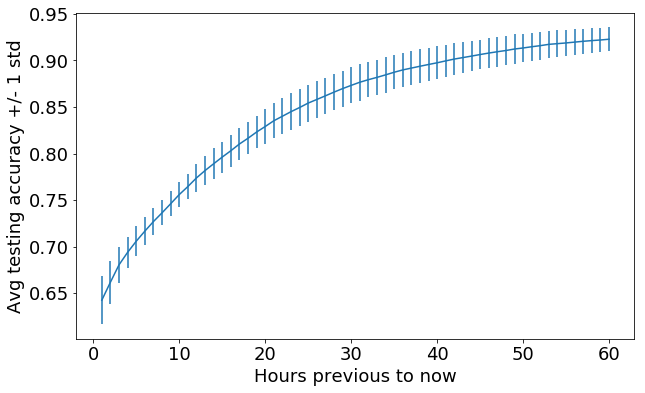

In [127]:
#Plot of mean and std dev of accuracies across the cross validation
mean_stat = np.array([])
std_stat = np.array([])

for lag_order in lags_to_try:
    
    mean_stat = np.append(mean_stat, np.mean(all_test_acc[lag_order-1]))
    std_stat = np.append(std_stat, np.std(all_test_acc[lag_order-1]))
    
#Plotting
font_size = 18;
fig = plt.figure(figsize=(10,6));
ax = plt.axes();

ax.errorbar(lags_to_try, mean_stat, yerr=std_stat)

plt.xlabel('Hours previous to now', fontsize=font_size)
plt.ylabel('Avg testing accuracy +/- 1 std', fontsize=font_size)

labels = ax.get_xticklabels();
plt.setp(labels, fontsize=font_size);
labels = ax.get_yticklabels();
plt.setp(labels, fontsize=font_size);



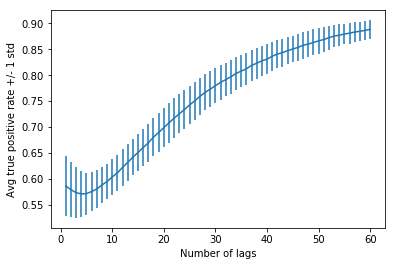

In [130]:
#Plot of mean and std dev of accuracies across the cross validation
mean_stat = np.array([])
std_stat = np.array([])

for lag_order in lags_to_try:
#     print(lag_order)
    this_lag_order_tpr = np.array([])
    
    for year_index in range(np.shape(sklearn_metrics[lag_order-1])[0]):
        
        this_lag_order_tpr = np.append(this_lag_order_tpr, sklearn_metrics[lag_order-1][year_index][1][1])
    
    mean_stat = np.append(mean_stat, np.mean(this_lag_order_tpr))
    std_stat = np.append(std_stat, np.std(this_lag_order_tpr))
    
# plt.plot(several_lags, mean_r_sq)
plt.errorbar(lags_to_try, mean_stat, yerr=std_stat)
plt.xlabel('Number of lags')
plt.ylabel('Avg true positive rate +/- 1 std')
plt.title('')

It appears that the increase in accuracy has leveled off around 60 lags, and the true positive rate is starting to at this point as well.  I will proceed with a 60 hour lag model.

I explore the true/false positive rates as done before with CSO outflows.

In [131]:
#Return false positive rates for desired true positive rate
want_true_pos = 0.90;
#Use 60 hour lag model
lag_order = 59;

actual_true_pos = np.array([])
false_pos_rate_for_this_true_pos = np.array([])
thresh_for_this_true = np.array([])
negative_classes = np.array([])


for year_index in range((len(un_years))):
    #The difference between desired and all true positive rates in the ROC curve
    roc_diff = all_test_roc[lag_order][year_index][1] - want_true_pos
    #Index of the closest to desired
    roc_index = np.argmin(np.abs(roc_diff))
    actual_true_pos = np.append(actual_true_pos, all_test_roc[lag_order][year_index][1][roc_index])
    false_pos_rate_for_this_true_pos = \
    np.append(false_pos_rate_for_this_true_pos, all_test_roc[lag_order][year_index][0][roc_index])
    thresh_for_this_true = np.append(thresh_for_this_true, all_test_roc[lag_order][year_index][2][roc_index])
    
    #Fraction of negative classifications
    negative_classes = np.append(negative_classes, sum(all_test_proba[lag_order][year_index][:,1] < \
              thresh_for_this_true[year_index])/np.float(len(all_test_proba[lag_order][year_index][:,1])))

In [132]:
#These should be close to 0.9
actual_true_pos

array([ 0.89986468,  0.90031521,  0.89995966,  0.90024631,  0.89928058,
        0.90030675,  0.89935435,  0.89981308,  0.8999519 ,  0.9       ])

In [133]:
false_pos_rate_for_this_true_pos

array([ 0.0376369 ,  0.09041653,  0.07810479,  0.06992337,  0.04824137,
        0.15347997,  0.06698407,  0.08298755,  0.07914212,  0.09298831])

In [134]:
np.mean(false_pos_rate_for_this_true_pos)

0.079990498631301477

The average false positive rate across the k-fold cross validation is 8%, much less than the baseline model's of 41%.  Here are the tresholds corresponding to 90% TPN.

In [135]:
thresh_for_this_true

array([ 0.51483271,  0.46582649,  0.54656258,  0.52195977,  0.45312233,
        0.31986343,  0.46826438,  0.49222699,  0.36099948,  0.42285845])

# To be done:  final steps for implementation <a id='final_steps'></a>
Following satisfactory cross-validation, the models will be trained on all years of data, and saved for future use on the NYC DEP website.

I will create a new notebook that will define a function that uses these trained models and takes as input a # time events x # predictors array, i.e. 60 x 3 for the bacteria model.

Key points for implementation:
1.  All inputs must be in the same units as the model is expecting
2.  The implemented model needs the same exact hourly inputs as data sources used here:
    3.  Rainfall (in/hr) from the NOAA station at JFK.  This was supplied directly to me from NYC DEP.
    4.  Water level (ft) from the Sandy Hook, NJ station.  Specifically, "Predicted" water level from here:  https://tidesandcurrents.noaa.gov/stationhome.html?id=8531680 .  Note that if using an internal NYC DEP data product, it would need to have the same reference as what the model was trained on (i.e. if the starting value is assigned a level of zero, needs to be same starting time between model training data and the real-time data used in implementation)
    5.  Air temperature (F) from the NOAA station at JFK.  This was pulled and cleaned from the web.
    
If data sources are changed, models need to be retrained.

## Hypothetical scenario <a id='hypothetical'></a>

To get a very rough estimate of the financial impact of a more accurate model, I make the assumption that 10% of the number of annual visitors to Coney Island Beach (taken from here:  https://www.nycgovparks.org/parks/coney-island-beach-and-boardwalk/dailyplant/23220) is proporational to the percentage of time the model predicts "safe water," according to < 1000 colonies FC / 100 mL.  According to the data, this is 71%.  The baseline model predicts 46%.  With the new model that has relatively low false positives, this is:

In [136]:
new_model_neg_classes = np.mean(negative_classes[0:-2])
new_model_neg_classes

0.68380144480905769

In [137]:
# Assume increase in visitors is directly proportional to predicted time of safe water
yearly_vis = 11453890 * 0.10
new_vis = yearly_vis*(new_model_neg_classes/baseline_neg_classes)
vis_increase = new_vis - yearly_vis
print(vis_increase)
print('More people per year')

560013.044671
More people per year


In [138]:
#If each additional person buys a $3 ice cream cone, how much additional revenue is this?
3*vis_increase

1680039.1340128148